In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(tidyverse)
})

### Nea. ancestry trajectories for different genomic regions (simulated individually)

Shown is the case of additivity ($h = 0.5$). Also mutation rate $=1e-8$ per bp per generation. This is slightly higher than what Kelley simulated ($7e-9$, roughly the mutation rate of non-synonymous mutations).

Clearly the larger proportion of deleterious sequence, the higher the impact of the Neanderthal genetic load.

Kelly simulated ~70Mb of exonic sequence and found that one needs ~10% admixture rate so that ~2-3% of Nea. ancestry survives over time. We find evidence of deleterious protein coding sequence, but also UTRs, promoter sequence and also a lot of "unidentified" non-coding sequence.

In total, our logistic regression analysis and analysis of distributions of Nea. ancestry shows that there is at least 200Mb sequence that hs been affected by selection against Nea. ancestry.

If all of that sequence behaves additively or near-dominantly, no Neanderthal ancestry would survive.

Maybe this is another evidence for recessivity of some of those regions? Protein coding + TF binding sequence? This would make different regions "compete" - recessive sequence would be prefered from Neanderthals, additive/dominant sequence would be selected against.

In [12]:
df_h <- lapply(c("exon", "promoter", "protein_coding", "tf_binding_site", "utr3"), function(r) {
lapply("0.5", function(h) {
    files <- list.files(path="../data/simulations/", pattern=paste0(r, "_h_", h, "_rep_.*trajectory.*"), full.names=TRUE)
    lapply(files, function(f) {
        suppressMessages(read_tsv(f) %>% mutate(rep=f, h=paste("dominance =", h), reg=r))
    }) %>% bind_rows
}) %>%
    bind_rows %>% 
    group_by(h, gen, reg) %>% summarise(nea_mean=mean(mean), nea_sd=mean(sd)) %>%
    ungroup
}) %>% bind_rows

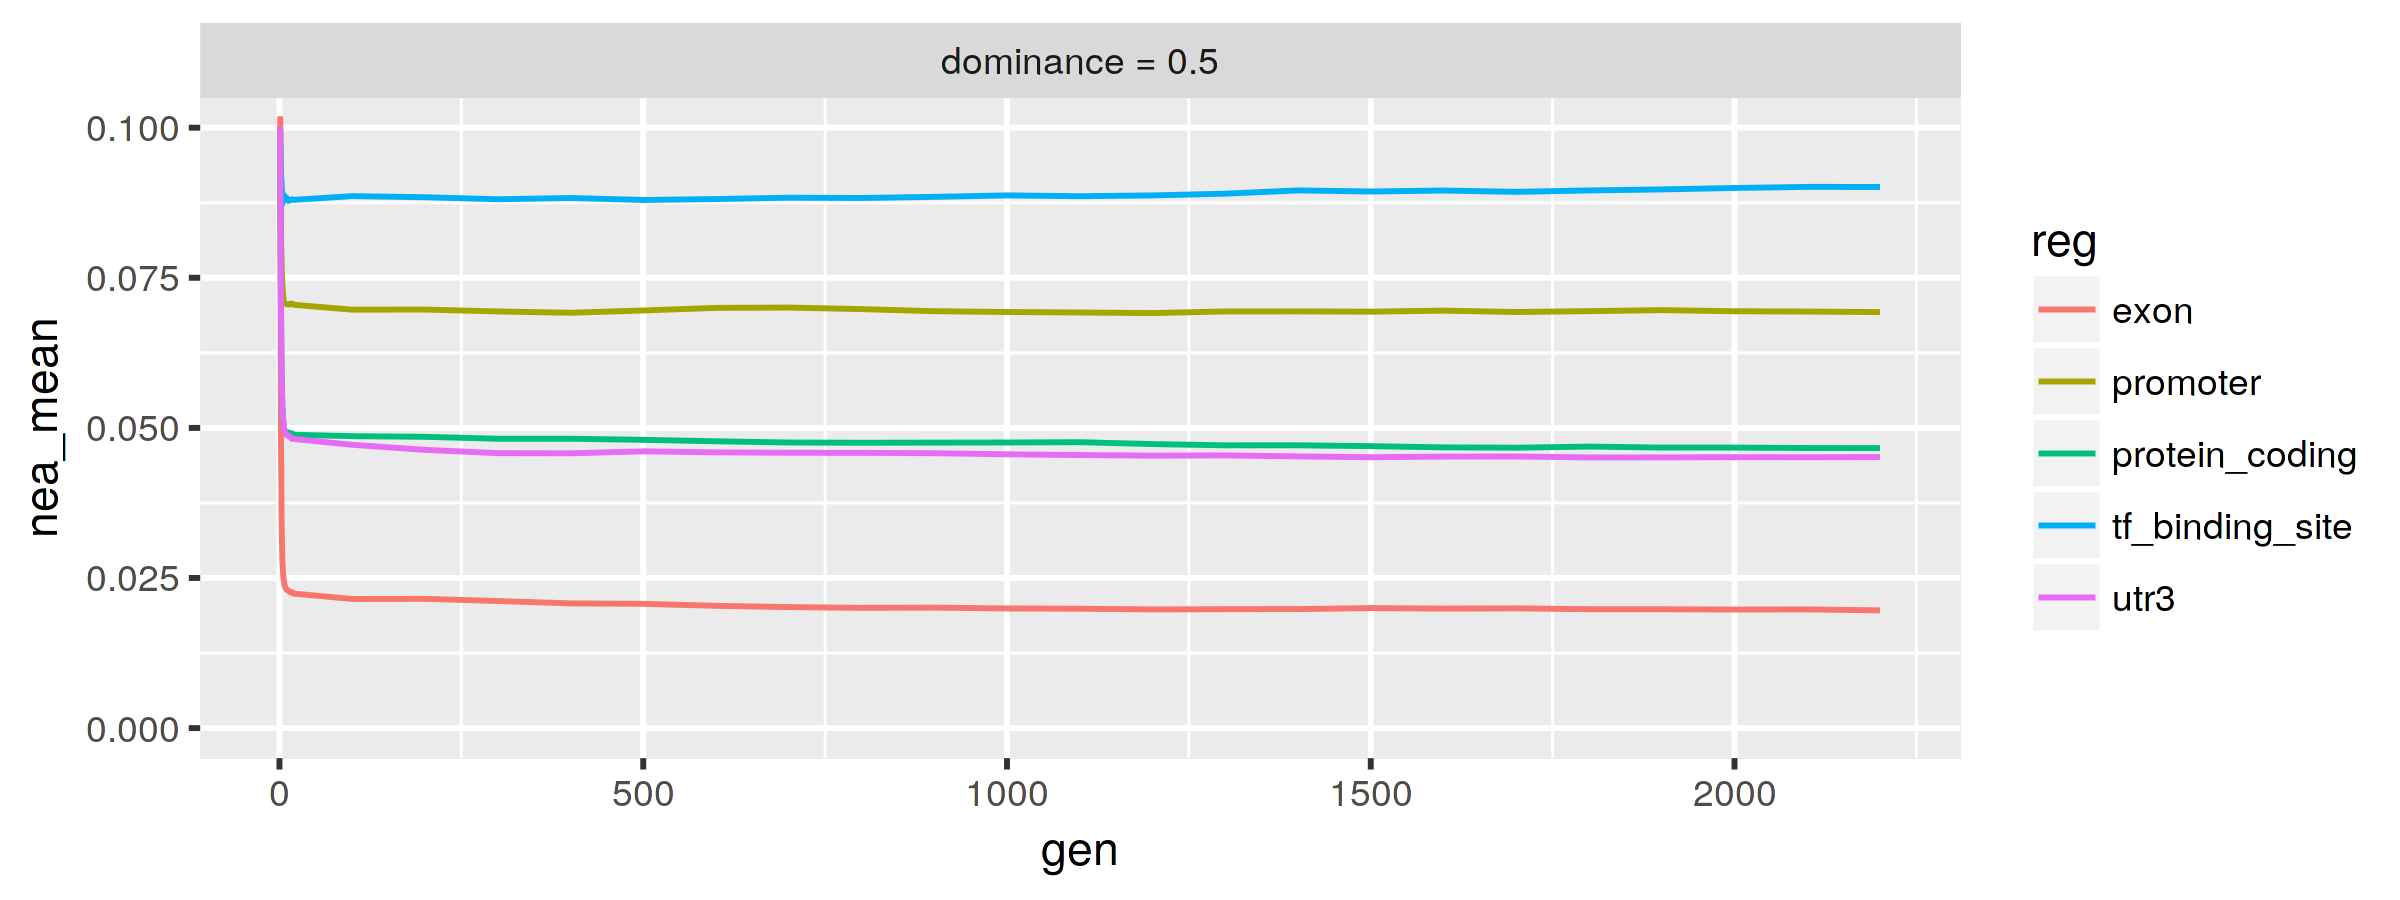

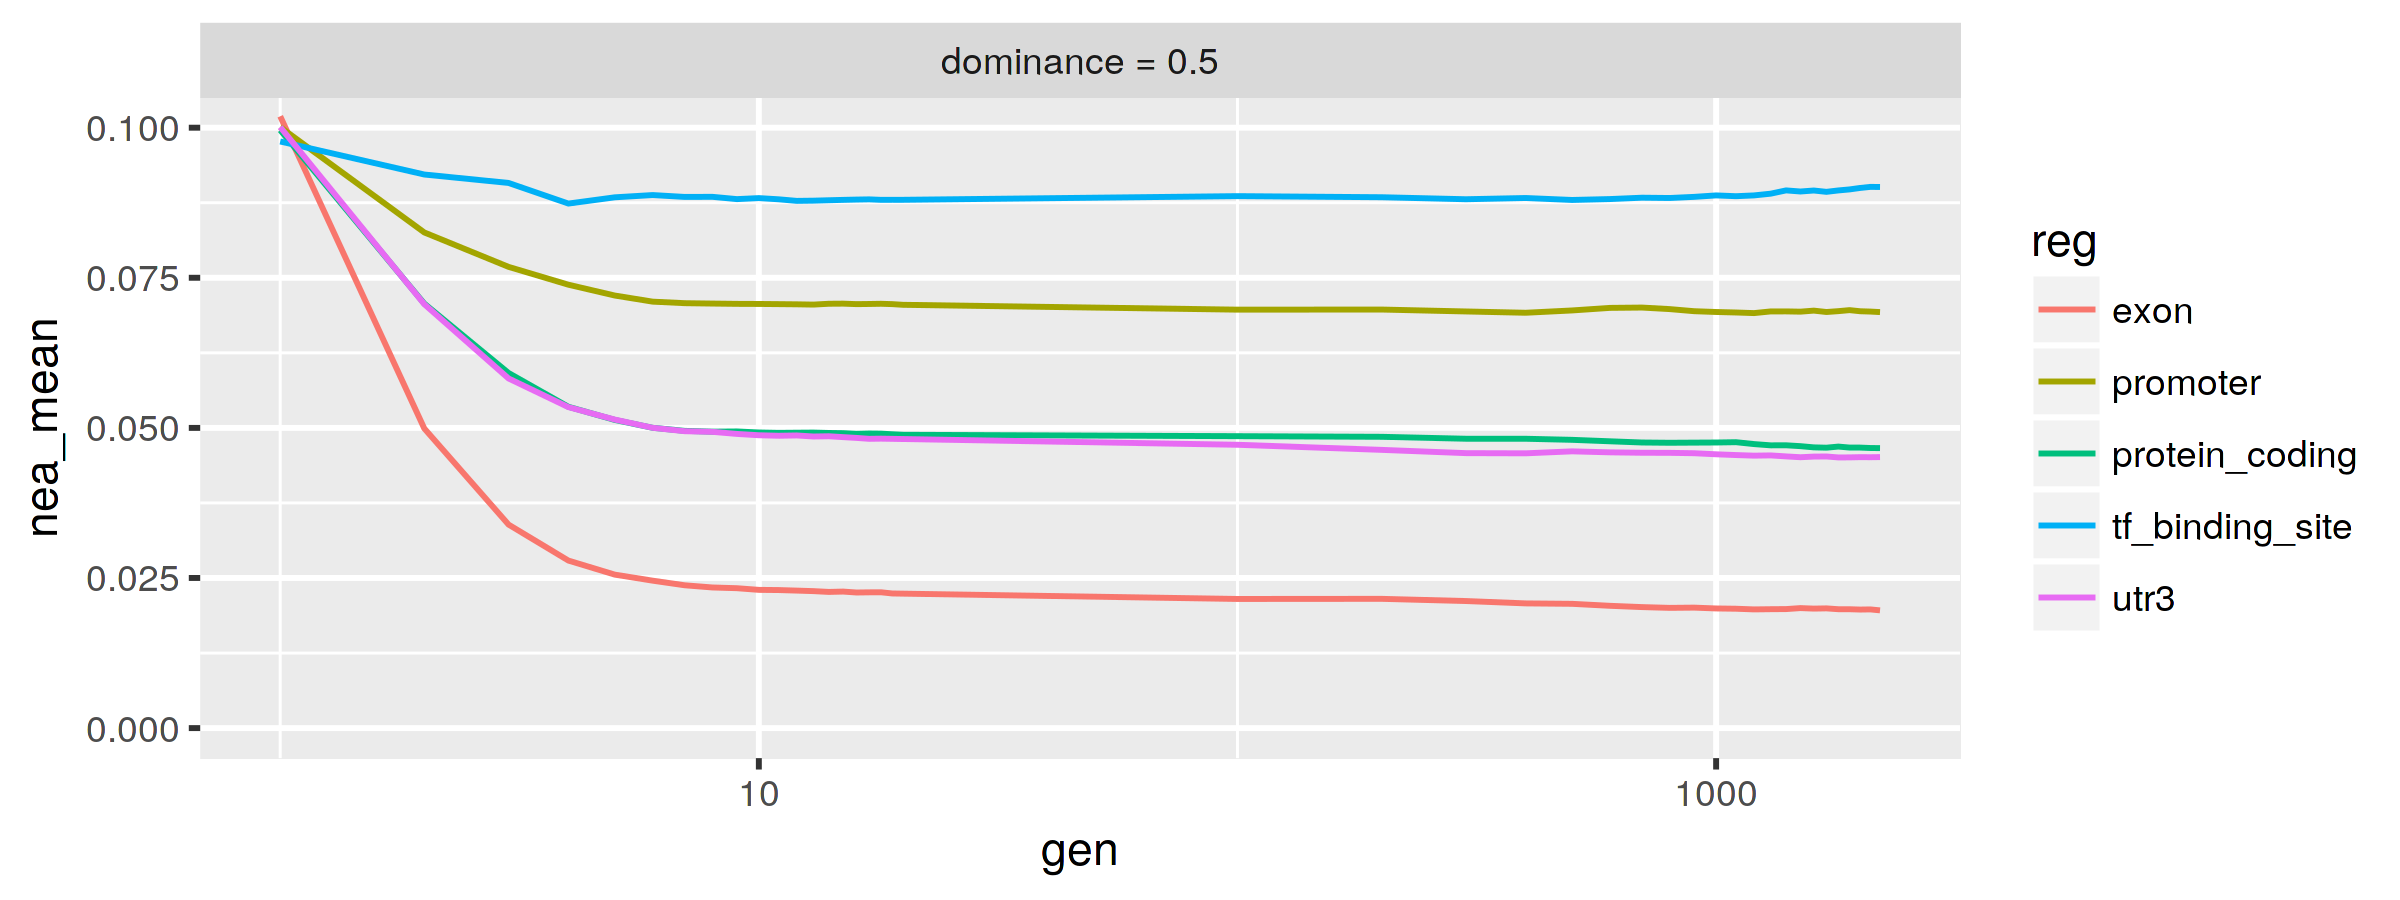

In [13]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1))
ggplot(df_h, aes(gen, nea_mean)) + geom_line(aes(color=reg)) + facet_grid(. ~ h) + coord_cartesian(y=c(0, 0.1)) + scale_x_log10()

In [2]:
read_vcf <- function(path) {
    readVcf(path, param=ScanVcfParam(info=c("S", "DOM", "PO", "GO", "MT"), geno="GT"))
}

In [3]:
get_muts <- function(vcf, mut_type) {
    mut_pos <- info(vcf)$MT == mut_type
    gr <- granges(vcf)[mut_pos]

    gt_mat <- geno(vcf)$GT[mut_pos, ]

    ind_gts <- apply(gt_mat, 2, function(gt) { str_count(gt, "1") })
    freq <- apply(ind_gts, 1, sum) / (2 * ncol(ind_gts))

    info_cols <- as.data.frame(info(vcf)[mut_pos, c("S", "DOM", "PO", "GO")])

    mcols(gr) <- bind_cols(info_cols, as.data.frame(freq), as.data.frame(ind_gts))
    names(gr) <- NULL

    # shift VCF coordinates back to the SLiM 0-based system
    gr <- shift(gr, shift=-1)

    sort(gr)
}

In [4]:
read_regions <- function(region) {
    regions_bed <- paste0("../data/slim_coords/", region, "_regions.bed")
    gr <- read_tsv(regions_bed, col_types="ciicdiii") %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)
    gr
}

In [5]:
read_sites <- function(region) {
    sites_bed <- paste0("../data/slim_coords/", region, "_all_sites.bed")
    gr <- read_tsv(sites_bed, col_types="ciiii") %>%
        select(real_chrom=chrom, real_start=start, real_end=end, start=slim_start, end=slim_end) %>%
        mutate(chrom=1) %>% 
        makeGRangesFromDataFrame(keep.extra.columns=TRUE)
    gr
}

In [6]:
transpose_sites <- function(sim_sites, real_sites) {
    hits <- findOverlaps(real_sites, sim_sites)
    transposed <- as.data.frame(mcols(real_sites)) %>%
        setNames(c("chrom", "start", "end")) %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>%
        .[queryHits(hits)]
    mcols(transposed) <- mcols(sim_sites)["freq"]

    transposed
}

In [7]:
get_markers <- function(vcf, region) {
    real_sites <- read_sites(region)
    sim_sites <- get_muts(vcf, mut_type=1)
    
    transpose_sites(sim_sites, real_sites)
}

In [8]:
nea_per_ind <- function(gr) {
    ind_counts <- as.data.frame(mcols(gr)) %>%
         select(starts_with("i")) %>%
         summarise_all(sum) %>%
         t %>%
         as.vector
    
    ind_counts / length(gr) / 2
}

In [32]:
vcf <- read_vcf("../data/simulations/protein_coding_h_0.5_rep_1_gen_2200.vcf.gz")

In [42]:
sites <- get_markers(vcf, "protein_coding")

In [43]:
sites

GRanges object with 29593 ranges and 1 metadata column:
          seqnames               ranges strand |      freq
             <Rle>            <IRanges>  <Rle> | <numeric>
      [1]     chr1   [1141886, 1141886]      * |     0.165
      [2]     chr1   [1195379, 1195379]      * |     0.035
      [3]     chr1   [1201486, 1201486]      * |     0.035
      [4]     chr1   [1354717, 1354717]      * |     0.015
      [5]     chr1   [1775023, 1775023]      * |      0.01
      ...      ...                  ...    ... .       ...
  [29589]    chr22 [50874929, 50874929]      * |     0.235
  [29590]    chr22 [50882427, 50882427]      * |      0.23
  [29591]    chr22 [50907508, 50907508]      * |     0.265
  [29592]    chr22 [50909778, 50909778]      * |     0.265
  [29593]    chr22 [51145136, 51145136]      * |     0.265
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths